Loading Data    

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.4 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Importing modules
import pandas as pd
import os
# Read data into papers
papers = pd.read_csv('full_context_PeerRead.csv')
# Print head
papers.head()

,right_citated_text,left_citated_text,source_abstract,source_author,source_id,source_title,source_venue,source_year,target_id,target_author,target_abstract,target_year,target_title,target_venue
0,andsyntactic parsing .Because RNNs make very f...,We conducted additional experiments on artific...,Deep Neural Networks (DNNs) are powerful model...,ilya sutskever;oriol vinyals;quoc v le,1409.3215v1,Sequence to Sequence Learning with Neural Netw...,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
1,.Because RNNs make very few domain-specific as...,We conducted additional experiments on artific...,Syntactic parsing is a fundamental problem in ...,oriol vinyals;lukasz kaiser;terry koo;slav pet...,1412.7449v1,Grammar as a Foreign Language,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
2,"; in a Pointer Network,the only way to generat...","Reproducibility. All code, data, and experimen...",We introduce a new neural architecture to lear...,oriol vinyals;meire fortunato;navdeep jaitly,1506.03134v1,Pointer Networks,NIPS,2015.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
3,". Recently, nsur . have shown superior perfor...","st like CWS and POS tagging, automatic prosody...",The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1511.00360v1,chuang ding;lei xie;jie yan;weini zhang;yang liu,Prosody affects the naturalness and intelligib...,2015,Automatic Prosody Prediction for Chinese Speec...,arxiv
4,model trained on the Google News dataset3.In a...,We begin by considering a document as the set ...,The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv


Data Cleaning

In [4]:
# Remove the columns
papers = papers.drop(columns=['source_author', 'source_id',
                              'source_venue', 'target_id', 'target_author',
                              'target_abstract', 'target_year', 'target_title',
                              'target_venue'], axis=1)
# Print out the first rows of papers
papers.head()

,right_citated_text,left_citated_text,source_abstract,source_title,source_year
0,andsyntactic parsing .Because RNNs make very f...,We conducted additional experiments on artific...,Deep Neural Networks (DNNs) are powerful model...,Sequence to Sequence Learning with Neural Netw...,2014.0
1,.Because RNNs make very few domain-specific as...,We conducted additional experiments on artific...,Syntactic parsing is a fundamental problem in ...,Grammar as a Foreign Language,2014.0
2,"; in a Pointer Network,the only way to generat...","Reproducibility. All code, data, and experimen...",We introduce a new neural architecture to lear...,Pointer Networks,2015.0
3,". Recently, nsur . have shown superior perfor...","st like CWS and POS tagging, automatic prosody...",The recently introduced continuous Skip-gram m...,Distributed Representations of Words and Phras...,2013.0
4,model trained on the Google News dataset3.In a...,We begin by considering a document as the set ...,The recently introduced continuous Skip-gram m...,Distributed Representations of Words and Phras...,2013.0


Remove punctuation/lower casing (SOURCE ABSTRACT FOCUS)

In [5]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = \
papers['source_abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0    deep neural networks (dnns) are powerful model...
1    syntactic parsing is a fundamental problem in ...
2    we introduce a new neural architecture to lear...
3    the recently introduced continuous skip-gram m...
4    the recently introduced continuous skip-gram m...
Name: paper_text_processed, dtype: object

Exploratory Analysis


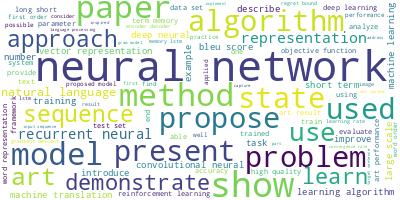

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Prepare data for LDA Analysis

In [7]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['deep', 'neural', 'networks', 'dnns', 'powerful', 'models', 'achieved', 'excellent', 'performance', 'difficult', 'learning', 'tasks', 'although', 'dnns', 'work', 'well', 'whenever', 'large', 'labeled', 'training', 'sets', 'available', 'cannot', 'used', 'map', 'sequences', 'sequences', 'paper', 'present', 'general']


In [8]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 1), (29, 1)]


LDA model training


In [ ]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [10]:
import pyLDAvis.gensim


Analyzing LDA model results


In [12]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pyLDAvis")

import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./lda_modeling'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './lda_modeling'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.077265  0.079641       1        1  32.177863
2     -0.007232  0.035409       2        1  26.678402
0     -0.154491 -0.015984       3        1  22.577015
1      0.084457 -0.099066       4        1  18.566720, topic_info=           Term         Freq         Total Category  logprob  loglift
47         lstm  4938.000000   4938.000000  Default  30.0000  30.0000
110        word  6556.000000   6556.000000  Default  29.0000  29.0000
83     sequence  5532.000000   5532.000000  Default  28.0000  28.0000
301   algorithm  5655.000000   5655.000000  Default  27.0000  27.0000
449  stochastic  2893.000000   2893.000000  Default  26.0000  26.0000
..          ...          ...           ...      ...      ...      ...
90        state  1359.113965   7424.659397   Topic4  -5.2667  -0.0142
13        based  1316.500379   7769.000380   Topic4  -5.2986  -0.0914
45     learning  1384.369218  15079.798939   Topic4  -5.2483  -0.7043
57       models  1278.898647   9577.758706   Topic4  -5.3275  -0.3296
10          art  1239.399948   6582.741650   Topic4  -5.3589   0.0140

[414 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4517      1  0.017693    absorb
4517      2  0.017693    absorb
4517      4  0.955415    absorb
1413      1  0.007839  academic
1413      2  0.964249  academic
...     ...       ...       ...
1993      2  0.011866   wordnet
111       1  0.546492     words
111       2  0.040148     words
111       3  0.153202     words
111       4  0.260063     words

[1155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])